In [22]:
#Confirming the path

import os
os.getcwd()

'/mnt/c/Users/hitga/Capstone/HouseTS Dataset/Capstone-Housing-Price-Prediction'

We will install anticipated libraries below for our data processing and modeling.

In [37]:
#Installing libraries for data prep and analysis
!pip install pandas
!pip install scikit-learn
!pip install scipy
!pip install matplotlib seaborn
!pip install seaborn
!pip install xgboost
!pip install shap




Using imported libraries, the dataset will be loaded to view the shape and first few rows of the data to inspect  before data analysis. df.describe() will also be executed to view the a statistical summary.

In [39]:
#Import libraries and load dataset
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

#Load Dataset
df = pd.read_csv('/mnt/c/Users/hitga/Capstone/HouseTS Dataset/Capstone-Housing-Price-Prediction/HouseTS.csv')
print ("Initial data shape:", df.shape)
print(df.head())

Initial data shape: (884092, 39)
         date  median_sale_price  median_list_price  median_ppsf  \
0  2012-03-31            46550.0           217450.0    31.813674   
1  2012-04-30            61870.0           245000.0    40.723982   
2  2012-05-31           125500.0           217450.0    63.913043   
3  2012-06-30           153000.0           189900.0    81.598080   
4  2012-07-31           165500.0           154000.0    81.598080   

   median_list_ppsf  homes_sold  pending_sales  new_listings  inventory  \
0        110.183666        14.0           23.0          44.0       64.0   
1        130.528256        22.0           29.0          56.0       69.0   
2        119.919216        24.0           40.0          63.0       60.0   
3        105.617353        34.0           46.0          50.0       57.0   
4         83.921175        39.0           49.0          42.0       50.0   

   median_dom  ...  Total Housing Units  Median Rent  Median Home Value  \
0        59.5  ...              

In [40]:
#Get Summary Statistics
df.describe()

,median_sale_price,median_list_price,median_ppsf,median_list_ppsf,homes_sold,pending_sales,new_listings,inventory,median_dom,avg_sale_to_list,...,Total Families Below Poverty,Total Housing Units,Median Rent,Median Home Value,Total Labor Force,Unemployed Population,Total School Age Population,Total School Enrollment,Median Commute Time,price
count,8.840920e+05,8.840920e+05,884092.000000,884092.000000,884092.000000,884092.000000,884092.000000,884092.000000,884092.000000,884092.000000,...,884092.000000,884092.000000,884092.000000,8.840920e+05,884092.000000,884092.000000,884092.000000,884092.000000,884092.000000,8.840920e+05
mean,3.941026e+05,4.229849e+05,223.068328,231.169836,76.722786,81.471457,92.910352,77.300772,61.289875,0.978253,...,21457.525088,8714.480844,1146.686284,3.147922e+05,11455.779512,829.769133,20998.337745,20998.337745,9687.919963,3.913289e+05
std,3.815481e+05,1.899201e+06,696.724208,290.120210,76.698331,85.327617,92.695852,89.041772,82.220497,0.063550,...,19554.169658,7588.635086,547.236746,2.672194e+05,10429.516147,954.753745,19008.391216,19008.391216,8841.743137,3.445383e+05
min,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,1.046432e+04
25%,1.850000e+05,1.990000e+05,110.639667,116.818175,19.000000,17.000000,24.000000,20.000000,26.000000,0.965158,...,4404.000000,1930.000000,852.000000,1.436000e+05,2320.000000,127.000000,4369.000000,4369.000000,1945.000000,1.897063e+05
50%,3.025000e+05,3.200000e+05,166.093929,173.142587,55.000000,57.000000,67.000000,50.000000,45.000000,0.982062,...,17489.000000,7426.000000,1114.000000,2.501000e+05,9299.000000,538.000000,17247.000000,17247.000000,7830.500000,3.050190e+05
75%,4.800000e+05,4.999000e+05,260.626280,270.181473,111.000000,119.000000,133.000000,103.000000,74.000000,0.998206,...,32991.000000,13564.000000,1446.000000,4.125000e+05,17702.000000,1192.000000,32290.000000,32290.000000,15013.000000,4.797111e+05
max,2.050000e+07,1.000000e+09,366700.000000,143015.398551,955.000000,1374.000000,1112.000000,1941.000000,7777.000000,1.906250,...,130605.000000,48734.000000,3501.000000,2.000001e+06,68735.000000,9735.000000,126948.000000,126948.000000,60956.000000,8.463116e+06


The output from the df.describe() shows the summary statistics for each column in the dataset. The key takeaways from this output:
The dataset is very large, containing 884K rows
The variables are highly skewed with extreme outliers (1B list price, 366K price per square foot, and 7777 days on the market).
Typical US housing values seem reasonable (Median home = 300K, median rent = 1100)
Socioeconomic factors provide context for housing markets.

In [41]:
#Map city code to city names
# Create a dictionary mapping city codes to full names
city_map = {
    'ATL': 'Atlanta',
    'ATX': 'Austin',
    'BOS': 'Boston',
    'BWI': 'Baltimore-Washington',
    'CHI': 'Chicago',
    'CIN': 'Cincinnati',
    'CLT': 'Charlotte',
    'DAL': 'Dallas',
    'DC': 'Washington DC',
    'DEN': 'Denver',
    'DET': 'Detroit',
    'HOU': 'Houston',
    'LA': 'Los Angeles',
    'LV': 'Las Vegas',
    'MIA': 'Miami',
    'MSP': 'Minneapolis-St. Paul',
    'NY': 'New York',
    'ORL': 'Orlando',
    'PDX': 'Portland',
    'PGH': 'Pittsburgh',
    'PHL': 'Philadelphia',
    'PHX': 'Phoenix',
    'RIV': 'Riverside',
    'SA': 'San Antonio',
    'SAC': 'Sacramento',
    'SD': 'San Diego',
    'SEA': 'Seattle',
    'SF': 'San Francisco',
    'STL': 'St. Louis',
    'TPA': 'Tampa'
}

# Map city codes to full names in a new column
df['city_full_name'] = df['city'].map(city_map)

# Verify the mapping
df[['city', 'city_full_name']].head()

,city,city_full_name
0,ATL,Atlanta
1,ATL,Atlanta
2,ATL,Atlanta
3,ATL,Atlanta
4,ATL,Atlanta


A dictionary was created to map the city code to the full city name for easy identification

In [42]:
#View data types of all columns
print("Column data types:\n", df.dtypes)

Column data types:
 date                             object
median_sale_price               float64
median_list_price               float64
median_ppsf                     float64
median_list_ppsf                float64
homes_sold                      float64
pending_sales                   float64
new_listings                    float64
inventory                       float64
median_dom                      float64
avg_sale_to_list                float64
sold_above_list                 float64
off_market_in_two_weeks         float64
city                             object
zipcode                           int64
year                              int64
bank                            float64
bus                             float64
hospital                        float64
mall                            float64
park                            float64
restaurant                      float64
school                          float64
station                         float64
supermarket         

The output from checking the data types show that date needs to be changed from an object to datetime, this will allow us to feature enginner the date and extract the month and year for time trend analysis. 
The zipcode needs to be converted to a string to maintain leading zeros and to be able to treat it as categorical. From the describe data above, we also need to remove the outliers to avoid data being skewed. 
Further cleaning and preprocessing to be performed is to check and remove any duplicate data, missing values verify data consistency by looking for zero or negative values and dropping them if they exist.
These actions will be completed in the next steps identified below.

In [28]:
#Date/Time Feature Engineering

df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day_of_week'] = df['date'].dt.dayofweek
df['quarter'] = df['date'].dt.quarter
df = df.drop(columns=['date'])

In [47]:
#Convert Zip code to string so treated as categorical
df['zipcode'] = df['zipcode'].astype(str)
print("\nUpdated 'zipcode' data type:", df['zipcode'].dtype)


Updated 'zipcode' data type: object


In [48]:
#Handle any infinite values
df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [49]:
#Check for Missing Values
print("NaNs before filling:\n", df.isna().sum())

NaNs before filling:
 date                            0
median_sale_price               0
median_list_price               0
median_ppsf                     0
median_list_ppsf                0
homes_sold                      0
pending_sales                   0
new_listings                    0
inventory                       0
median_dom                      0
avg_sale_to_list                0
sold_above_list                 0
off_market_in_two_weeks         0
city                            0
zipcode                         0
year                            0
bank                            0
bus                             0
hospital                        0
mall                            0
park                            0
restaurant                      0
school                          0
station                         0
supermarket                     0
Total Population                0
Median Age                      0
Per Capita Income               0
Total Families Below Pover

In [50]:
#Check for duplicate rows and drop 
duplicate_count = df.duplicated().sum()
if duplicate_count > 0:
    df = df.drop_duplicates()
    print("Duplicate rows dropped. New shape:", df.shape)
else:
    print("No duplicate rows found.")


No duplicate rows found.


In [51]:
#Remove any outliers
from scipy import stats

z_scores = stats.zscore(df.select_dtypes(include=['float64', 'int64']))
df = df[(abs(z_scores) < 3).all(axis=1)]

Prepare categorical features for modeling by converting them into numeric codes to make them compatible with meachine learning algorithms.

In [52]:
#Label Encode
from sklearn.preprocessing import LabelEncoder

cat_cols = [c for c in df.select_dtypes(include=['category']).columns if c != 'city_full_name']

for col in cat_cols:
    if not pd.api.types.is_categorical_dtype(df[col]):
        df[col] = df[col].astype('category')
    df[col] = df[col].cat.codes



In [53]:
# Scale numerical values
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first = True)
numeric_cols = df_encoded.select_dtypes(include=['float64', 'int64']).columns
scaler=StandardScaler()
df_encoded[numeric_cols] = scaler.fit_transform(df_encoded[numeric_cols])


In [54]:
#Check for any missing or infinite values after processing
import numpy as np

print("Missing values after processing:", df_encoded.isna().sum().sum())

# Select numeric columns only
numeric_cols = df_encoded.select_dtypes(include=[np.number]).columns

# Check for infinite values only in numeric columns
inf_count = np.isinf(df_encoded[numeric_cols]).sum().sum()
print("Infinite values after processing:", inf_count)


Missing values after processing: 0
Infinite values after processing: 0


After performing all processing, data was double checked for missing or infinte values.

In [56]:
#Preview Cleaned, encoded, and scaled data
print(df_encoded.head())

         date  median_sale_price  median_list_price  median_ppsf  \
0  2012-03-31          -1.302534          -0.586751    -1.307726   
1  2012-04-30          -1.234972          -0.474141    -1.233422   
2  2012-05-31          -0.954358          -0.586751    -1.040046   
3  2012-06-30          -0.833081          -0.699362    -0.892569   
4  2012-07-31          -0.777956          -0.846103    -0.892569   

   median_list_ppsf  homes_sold  pending_sales  new_listings  inventory  \
0         -0.708705   -0.898503      -0.736741     -0.538226  -0.052499   
1         -0.540974   -0.770475      -0.649954     -0.375150   0.025265   
2         -0.628440   -0.738468      -0.490845     -0.280022  -0.114710   
3         -0.746351   -0.578432      -0.404058     -0.456688  -0.161368   
4         -0.925225   -0.498415      -0.360664     -0.565405  -0.270237   

   median_dom  ...  Median Rent  Median Home Value  Total Labor Force  \
0    0.067152  ...    -0.758792           0.012131          -0.7860

In [57]:
#Save to CSV for later use
df_encoded.to_csv('cleaned_scaled_data.csv', index=False)
print("Cleaned and scaled data saved to 'cleaned_scaled_data.csv'")

Cleaned and scaled data saved to 'cleaned_scaled_data.csv'


In [58]:
# Convert city numeric codes to categorical dtype
df['city'] = df['city'].astype('category')

# Check the categories
print(df['city'].cat.categories)

# Label encode the city
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['city_encoded'] = le.fit_transform(df['city'])

# Now 'city_encoded' is a numeric feature 
print(df[['city', 'city_encoded']].head())


Index(['ATL', 'ATX', 'BOS', 'BWI', 'CHI', 'CIN', 'CLT', 'DAL', 'DC', 'DEN',
       'DET', 'HOU', 'LA', 'LV', 'MIA', 'MSP', 'NY', 'ORL', 'PDX', 'PGH',
       'PHL', 'PHX', 'RIV', 'SA', 'SAC', 'SD', 'SEA', 'SF', 'STL', 'TPA'],
      dtype='object')
  city  city_encoded
0  ATL             0
1  ATL             0
2  ATL             0
3  ATL             0
4  ATL             0


Now that all data has been cleaned, processed and saved. I will now compare linear regression and random Forest models.

In [59]:
#Linear Regression and Random Forest Comparison side by side
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib  # for pipeline caching

# Reduce data size to 30% for quicker testing
df_sample = df.sample(frac=0.3, random_state=42)
X = df_sample.drop('price', axis=1)
y = df_sample['price']

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Identify columns
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_cols = X_train.select_dtypes(include=['number']).columns.tolist()

# Fill missing & convert types (on train and test)
for col in categorical_cols:
    X_train[col] = X_train[col].astype(str).fillna('missing')
    X_test[col] = X_test[col].astype(str).fillna('missing')
for col in numeric_cols:
    X_train[col] = pd.to_numeric(X_train[col], errors='coerce').fillna(0)
    X_test[col] = pd.to_numeric(X_test[col], errors='coerce').fillna(0)

# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=True), categorical_cols),
        ('num', 'passthrough', numeric_cols)
    ]
)

memory = joblib.Memory(location='./cache_dir', verbose=0)

# Define pipelines for both models
pipelines = {
    "Random Forest": Pipeline([
        ('preprocessor', preprocessor),
        ('model', RandomForestRegressor(n_estimators=20, random_state=42, n_jobs=-1))
    ], memory=memory),

    "Linear Regression": Pipeline([
        ('preprocessor', preprocessor),
        ('model', LinearRegression())
    ], memory=memory)
}

for model_name, pipeline in pipelines.items():
    print(f"== {model_name} ==")
    # Cross-validation with 3 folds and parallel jobs
    cv_scores = cross_val_score(
        pipeline, X_train, y_train,
        cv=3,
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )
    rmse_cv = np.sqrt(-cv_scores)
    print(f"CV RMSE scores: {rmse_cv}")
    print(f"Mean CV RMSE: {rmse_cv.mean():.2f}")

    # Fit final model on full training data
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    # Calculate test metrics
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
    mae_test = mean_absolute_error(y_test, y_pred)
    r2_test = r2_score(y_test, y_pred)

    print(f"Test RMSE: {rmse_test:.2f}")
    print(f"Test MAE: {mae_test:.2f}")
    print(f"Test R^2: {r2_test:.3f}\n")




== Random Forest ==
CV RMSE scores: [33503.86342121 32945.96121167 33150.25909669]
Mean CV RMSE: 33200.03
Test RMSE: 31404.00
Test MAE: 17570.05
Test R^2: 0.979

== Linear Regression ==
CV RMSE scores: [50433.90732739 49341.11043227 50115.00326018]
Mean CV RMSE: 49963.34
Test RMSE: 50902.59
Test MAE: 29925.48
Test R^2: 0.946



Based on the outputs of both models, Random Forest outperformed the linear regression model in predicting housing prices. It achieved a lower test RMSE and MAE and a higher R^2 score indicating it captures the varience in the data more accurately. Overall it provides a more precise and reliable prediction for this dataset, likely die to its ability to model complex, non-linear relationships.

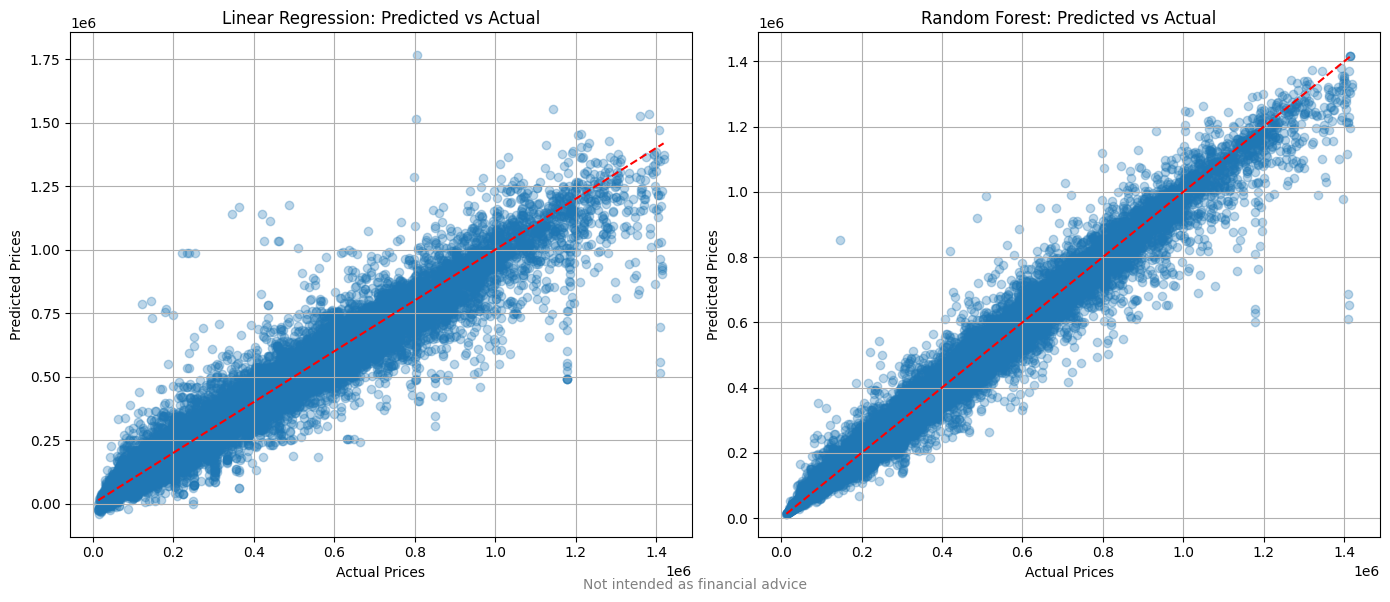

In [60]:
#Plot predicted vs actual housing prices Linear Regression and Random Forest
import matplotlib.pyplot as plt

# Make predictions without retraining
y_pred_lr = pipelines["Linear Regression"].predict(X_test)
y_pred_rf = pipelines["Random Forest"].predict(X_test)

# Create side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Linear Regression plot
axes[0].scatter(y_test, y_pred_lr, alpha=0.3)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
axes[0].set_title("Linear Regression: Predicted vs Actual")
axes[0].set_xlabel("Actual Prices")
axes[0].set_ylabel("Predicted Prices")
axes[0].grid(True)

# Random Forest plot
axes[1].scatter(y_test, y_pred_rf, alpha=0.3)
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
axes[1].set_title("Random Forest: Predicted vs Actual")
axes[1].set_xlabel("Actual Prices")
axes[1].set_ylabel("Predicted Prices")
axes[1].grid(True)
fig.text(0.5, 0.01, "Not intended as financial advice", ha='center', fontsize=10, color='gray')

plt.tight_layout()
plt.show()

The scatter plots of actual vs. predicted prices show the random Forest model are closer to the line compared to linear regression. This indicates the Random Forest predictions are generally more accurate and consistent with less deviation from actual values.

In [61]:
#Get top 10 features for each model

import pandas as pd
import numpy as np

# ----- Random Forest -----
rf_model = pipelines["Random Forest"].named_steps['model']
rf_preprocessor = pipelines["Random Forest"].named_steps['preprocessor']

# Get feature names after preprocessing
cat_features = rf_preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
num_features = numeric_cols
all_features = np.concatenate([cat_features, num_features])

# RF feature importances
rf_importances = pd.Series(rf_model.feature_importances_, index=all_features)
rf_top10 = rf_importances.sort_values(ascending=False).head(10)
print("Top 10 Random Forest Features:\n", rf_top10)

# ----- Linear Regression -----
lr_model = pipelines["Linear Regression"].named_steps['model']
lr_preprocessor = pipelines["Linear Regression"].named_steps['preprocessor']

# Get coefficients
lr_coeffs = pd.Series(lr_model.coef_, index=all_features)
lr_coeffs_abs = lr_coeffs.abs()
lr_top10 = lr_coeffs_abs.sort_values(ascending=False).head(10)
print("\nTop 10 Linear Regression Features (by absolute coefficient):\n", lr_top10)


Top 10 Random Forest Features:
 median_sale_price      0.743414
median_list_price      0.190013
Median Home Value      0.022753
year                   0.003712
median_list_ppsf       0.002911
median_ppsf            0.002742
Median Rent            0.001869
Per Capita Income      0.001679
Total Housing Units    0.001516
inventory              0.001427
dtype: float64

Top 10 Linear Regression Features (by absolute coefficient):
 Median Age          2412.715966
bank                 599.981608
hospital             291.364203
year                 249.789727
median_ppsf          167.836996
homes_sold           158.092558
median_list_ppsf     137.754712
restaurant           132.144514
new_listings         107.745547
city_NY              101.700994
dtype: float64


Output above shows the top 10 features relevant to each model.

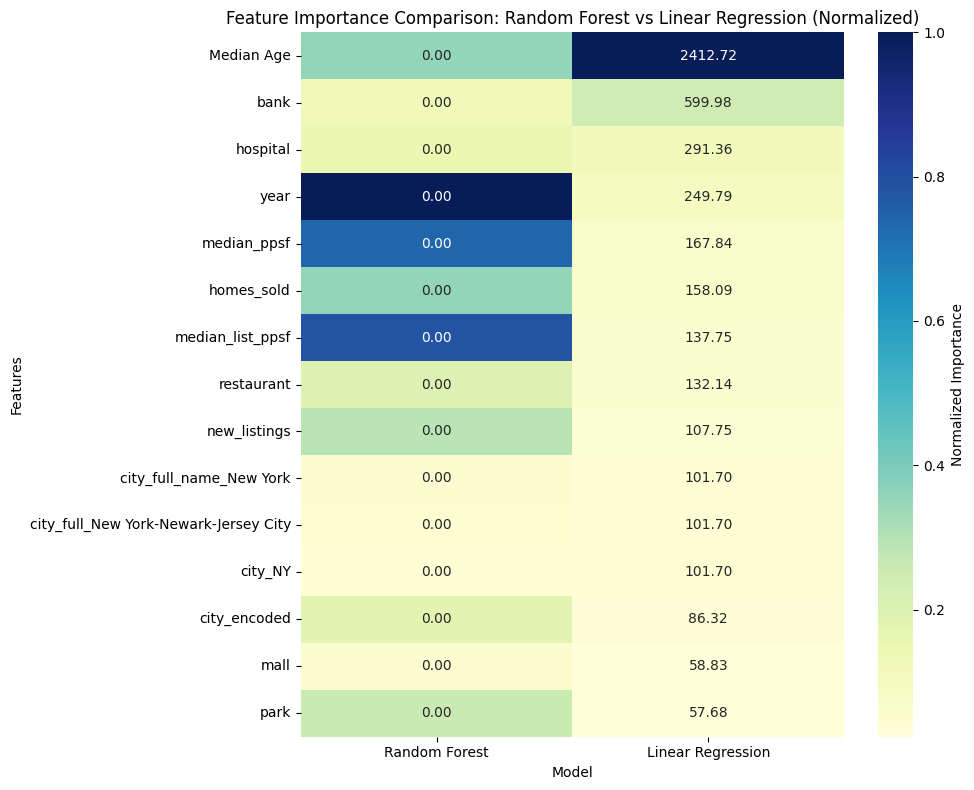

In [79]:
#Create heatmap to reflect relative importnace within each model to see which features each model favors


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

# ----- Extract feature names -----
rf_model = pipelines["Random Forest"].named_steps['model']
rf_preprocessor = pipelines["Random Forest"].named_steps['preprocessor']
cat_features = rf_preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
all_features = np.concatenate([cat_features, numeric_cols])

# ----- Feature importances -----
rf_importances = pd.Series(rf_model.feature_importances_, index=all_features)
lr_model = pipelines["Linear Regression"].named_steps['model']
lr_coeffs = pd.Series(lr_model.coef_, index=all_features).abs()  

# ----- Combine into DataFrame -----
feat_df = pd.DataFrame({
    "Random Forest": rf_importances,
    "Linear Regression": lr_coeffs
})

# ----- Select top 15 features by either model -----
top_features = feat_df.max(axis=1).sort_values(ascending=False).head(15).index
feat_df_top = feat_df.loc[top_features]

# ----- Normalize each column independently -----
feat_df_norm = feat_df_top / feat_df_top.max()

# ----- Plot heatmap -----
plt.figure(figsize=(10, 8))
sns.heatmap(feat_df_norm, annot=feat_df_top, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Normalized Importance'})
plt.title("Feature Importance Comparison: Random Forest vs Linear Regression (Normalized)")
plt.ylabel("Features")
plt.xlabel("Model")
plt.tight_layout()
plt.show()


This heatmap shows the comparison of feature importance for both the Random Forest and Linear Regression model.

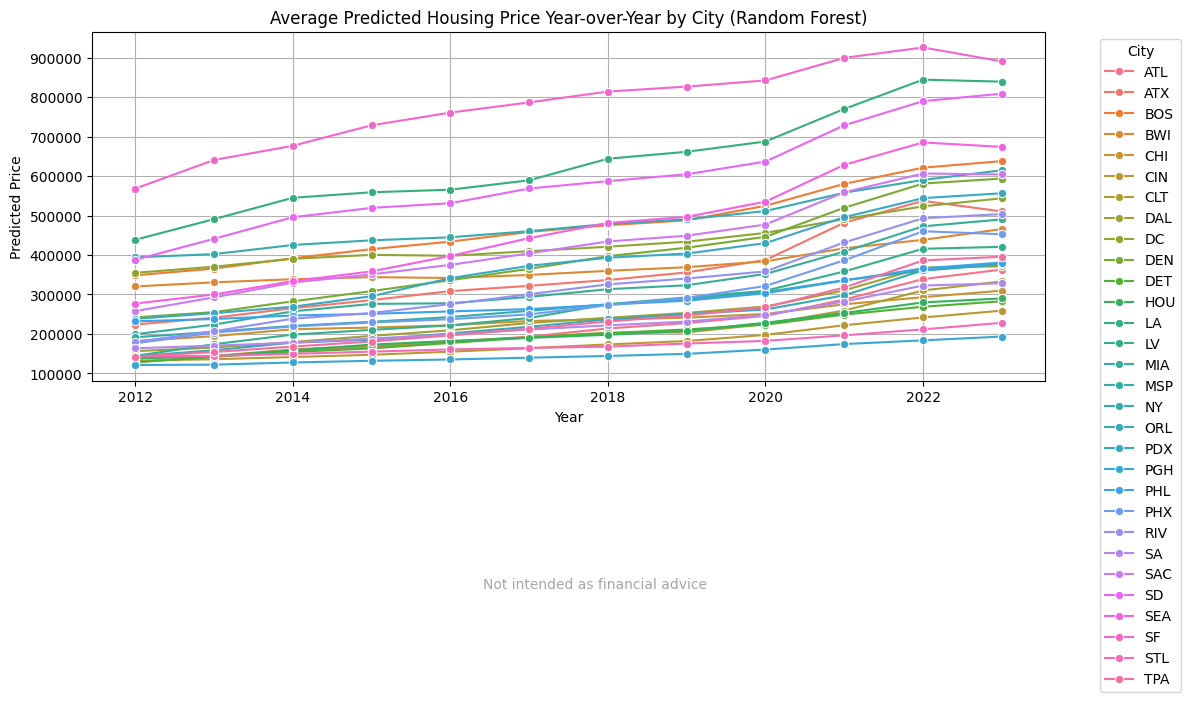

In [78]:
#Random Forest model by city and year
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Make predictions with the trained Random Forest pipeline
df_sample = df.copy()  # or use a smaller sample if needed
X_all = df_sample.drop('price', axis=1)
df_sample['predicted_price'] = pipelines["Random Forest"].predict(X_all)

# Aggregate by city and year
avg_price = df_sample.groupby(['city', 'year'], observed=True)['predicted_price'].mean().reset_index()

# Plot year-over-year trends
plt.figure(figsize=(12, 6))
sns.lineplot(data=avg_price, x='year', y='predicted_price', hue='city', marker='o')
plt.title("Average Predicted Housing Price Year-over-Year by City (Random Forest)")
plt.ylabel("Predicted Price")
plt.xlabel("Year")
plt.legend(title='City', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.figtext(0.5, 0.01, "Not intended as financial advice", ha='center', fontsize=10, color='gray', alpha=0.7)

plt.tight_layout()
plt.show()



The time series plot above shows the predicted housing prices year over year. Below I break out an individual time series plot for each city.

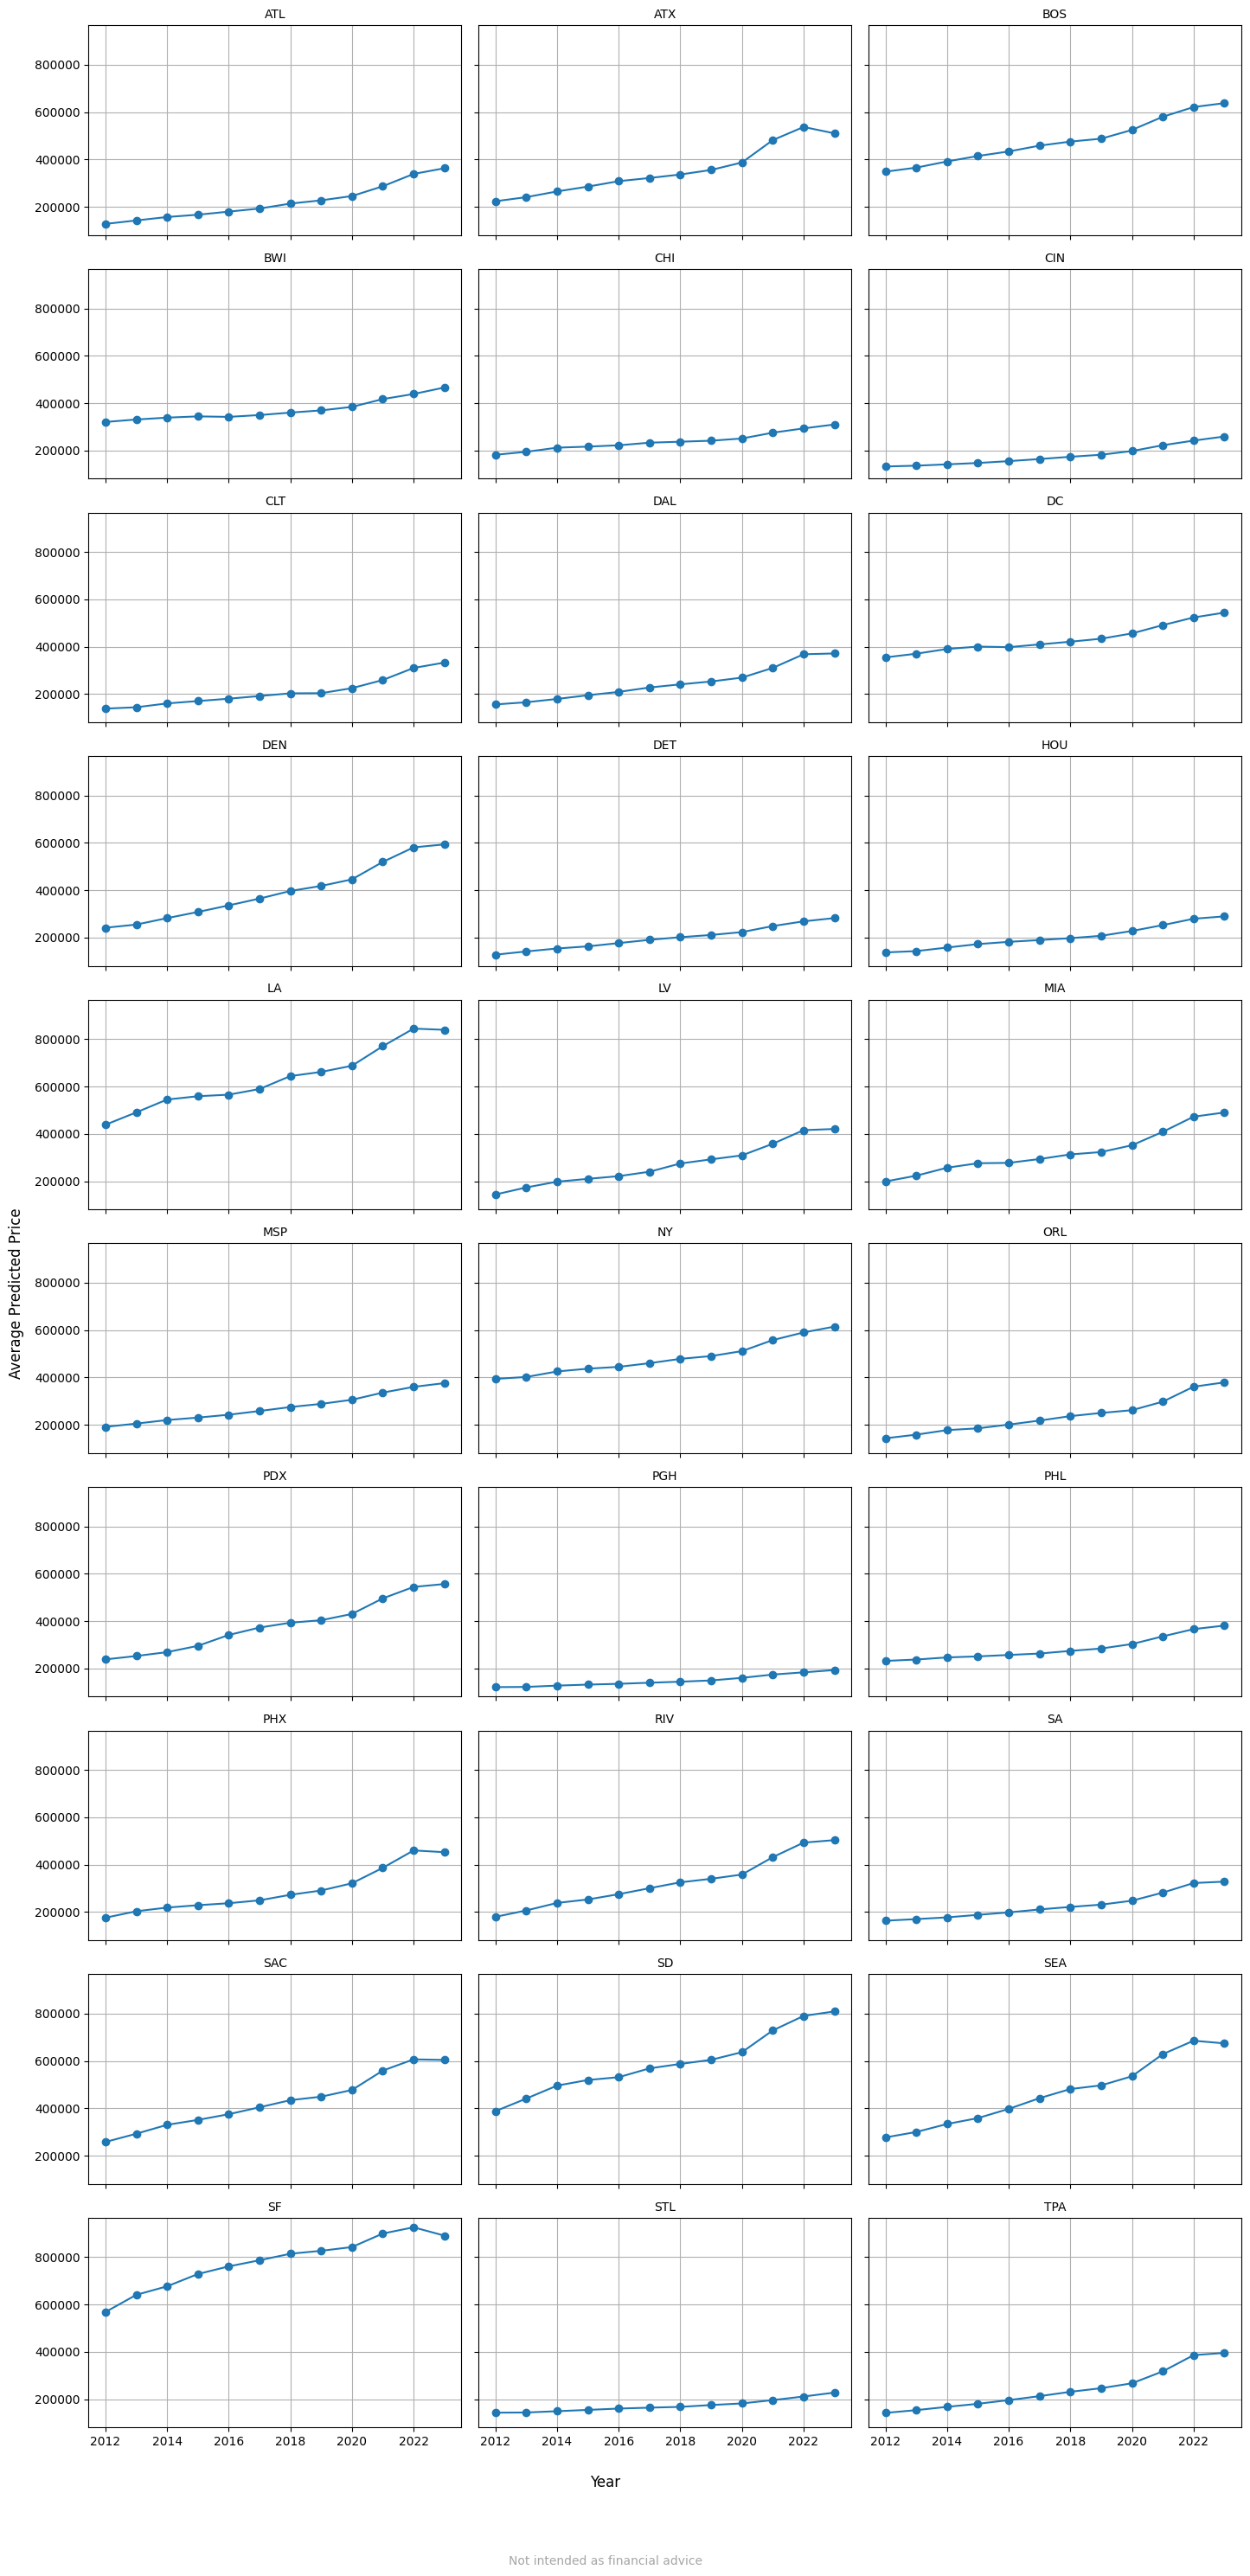

In [74]:
# One plot per city
import matplotlib.pyplot as plt
import math

# Unique cities
cities = avg_price['city'].unique()

# Grid layout: 3 plots per row (adjust as needed)
n_cols = 3
n_rows = math.ceil(len(cities) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 3*n_rows), sharex=True, sharey=True)
axes = axes.flatten()  # flatten for easy indexing

for i, city in enumerate(cities):
    city_data = avg_price[avg_price['city'] == city]
    axes[i].plot(city_data['year'], city_data['predicted_price'], marker='o')
    axes[i].set_title(city, fontsize=10)
    axes[i].grid(True)

# Turn off any extra axes if cities < n_rows*n_cols
for j in range(i+1, len(axes)):
    axes[j].axis('off')

# Axis labels
fig.text(0.5, 0.04, 'Year', ha='center', fontsize=12)
fig.text(0.04, 0.5, 'Average Predicted Price', va='center', rotation='vertical', fontsize=12)
plt.figtext(0.5, 0.01, "Not intended as financial advice", ha='center', fontsize=10, color='gray', alpha=0.7)

plt.tight_layout(rect=[0.05, 0.05, 1, 1])
plt.show()




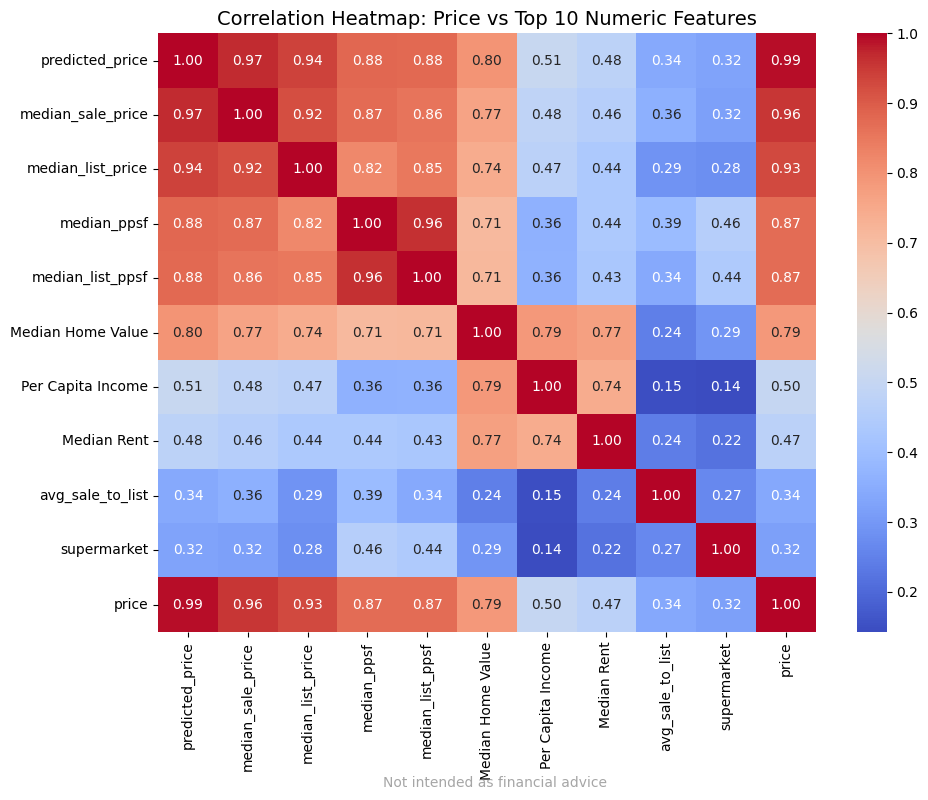

In [76]:
#Generate heatmap
import seaborn as sns
import matplotlib.pyplot as plt

# Keep only numeric columns
numeric_df = df_sample.select_dtypes(include=['number'])

# Compute correlations with target
corr_matrix = numeric_df.corr()
target_corr = corr_matrix['price'].abs().sort_values(ascending=False)

# Select top 10 correlated features (excluding price itself)
top_features = target_corr.drop('price').head(10).index.tolist()

# Subset correlation matrix for heatmap
top_corr = numeric_df[top_features + ['price']].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(top_corr, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title("Correlation Heatmap: Price vs Top 10 Numeric Features", fontsize=14)
plt.figtext(0.5, 0.01, "Not intended as financial advice", ha='center', fontsize=10, color='gray', alpha=0.7)

plt.tight_layout()
plt.show()



The heatmap helps visualize the correlation between the target variable of price and the top 10 numeric features strongly associated with it. It shows both the strength and direction of the relationships and helps identify which features are most influential in predicting the housing prices.